# GOALS
* Binary classification supervised learning
* Features: Genomic sequence, 4 letters with their order being very important
* Label: True or False - whether resistant or not to an antibiotic (or class of antibiotics)
* The genomic string should be tokenized first into the four letters G,C,T,A
* The models should be able to deal with text sequences while considering the order
* As the dataset is well balanced 0.502 being False with the others being True - the guessing accuracy / sanity check = 50%
* Initial RNNs 67% 
* Conv1D + Bidirectional GRU = 81%
* Presenting the model codons instead of nucleotides = 99%


In [1]:
# IMPORT MODULES

import os
import keras
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Embedding, LSTM
from keras import regularizers, layers, preprocessing
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf

print(os.listdir("../input"))

Using TensorFlow backend.


['dataset.npy']


# DATA

In [2]:
# Load the dataset.npy

DataRaw = np.load('../input/dataset.npy', allow_pickle=True)
print(type(DataRaw))
print(DataRaw.ndim)
DataRaw

<class 'numpy.ndarray'>
0


array({'resistant': array([False, False, False, ...,  True,  True, False]), 'genes': array(['ATGCACTACCGTATGATCCCCCTTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACCCGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATCGTGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       ...,
       'ATGCACTACCGTATGATTCACTGGATGATGGAAACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTAC

In [3]:
# As a dictionary
Datadict = DataRaw[()]
print(Datadict)

# As a dataframe
DataDf = pd.DataFrame.from_dict(Datadict)
print(DataDf.shape)
DataDf

{'resistant': array([False, False, False, ...,  True,  True, False]), 'genes': array(['ATGCACTACCGTATGATCCCCCTTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACCCGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATCGTGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       ...,
       'ATGCACTACCGTATGATTCACTGGATGATGGAAACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTC

,resistant,genes
0,False,ATGCACTACCGTATGATCCCCCTTCACTGGATGATGGAAATTGACT...
1,False,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...
2,False,ATGCACTACCGTATGATTCACTGGATCGTGATGGAAATTGACTGCA...
3,False,ATGCACTACCGTATGATTCACTGGGTGATGGAAATTGACTGCAATG...
4,False,ATGCACGACCGTATCATTCACTGGATGATGGAAATTGACTGCAATG...
5,False,ATGCACTACCGTATGATTCGCTGGATGATGGAAATTGACTGCAATG...
6,True,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...
7,True,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...
8,False,ATGCACTATATGATTCACTGGATGATGGAAATTGACTGCAATGGCT...
9,True,ATGCACTACCGTATGATTCACTGGATGATGGAAACTTGACTGCAAT...


In [4]:
# Mean  / Max / Min column width

DataDf.fillna('').astype(str).apply(lambda x:x.str.len()).max()

resistant      5
genes        156
dtype: int64

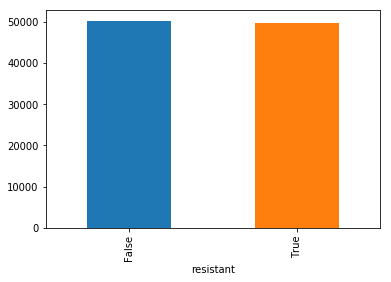

In [5]:
# Is the data balanced ?

DataDf.groupby('resistant').size().plot.bar()
plt.show()

In [6]:
# Tokenize from characters to integers (sequences and then pad / truncate data)

Datatok = DataDf.copy()
maxlen = 160 # cut off after this number of characters in a string

max_words = 4 # considers only the top number of characters in the dictionary A C T G
max_features = max_words

tokenizer = Tokenizer(num_words=max_words, char_level=True)
tokenizer.fit_on_texts(list(Datatok['genes']))
sequences = tokenizer.texts_to_sequences(list(Datatok['genes']))
word_index = tokenizer.word_index
Xpad = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post', value=0)

print('Found %s unique tokens.' % len(word_index))
print('word_index', word_index)

Found 4 unique tokens.
word_index {'a': 1, 't': 2, 'c': 3, 'g': 4}


In [7]:
# Separate the label

labels = np.asarray(Datatok['resistant'])
print(Xpad.shape)
print(labels.shape)

(100000, 160)
(100000,)


In [8]:
# Check a sample

rowNum = 37149
print(Datatok['genes'][rowNum])
print(sequences[rowNum])
print(Xpad[rowNum])
print(labels[rowNum])

ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA
[1, 2, 3, 1, 3, 2, 1, 3, 3, 2, 1, 2, 1, 2, 2, 3, 1, 3, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 3, 2, 3, 1, 1, 2, 3, 2, 3, 3, 2, 1, 1, 2, 1, 1, 2, 1, 3, 2, 2, 2, 2, 3, 2, 3, 2, 3, 2, 2, 1, 1, 2, 2, 1, 3, 1, 3, 2, 2, 3, 2, 3, 1, 3, 1, 1, 1, 3, 1, 3, 2, 2, 1, 1, 3, 1, 2, 2, 1, 1, 1, 2, 3, 2, 1, 3, 3, 2, 3, 1, 3, 1, 1, 2, 1, 2, 2, 3, 2, 1, 3, 3, 1, 1, 3, 2, 2, 1]
[1 2 3 1 3 2 1 3 3 2 1 2 1 2 2 3 1 3 2 1 2 1 2 1 1 1 2 2 1 3 2 3 1 1 2 3 2
 3 3 2 1 1 2 1 1 2 1 3 2 2 2 2 3 2 3 2 3 2 2 1 1 2 2 1 3 1 3 2 2 3 2 3 1 3
 1 1 1 3 1 3 2 2 1 1 3 1 2 2 1 1 1 2 3 2 1 3 3 2 3 1 3 1 1 2 1 2 2 3 2 1 3
 3 1 1 3 2 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
True


In [9]:
# Create train & val and test datasets with inital shuffle (as the original dataset may be arranged)

training_samples = int(Xpad.shape[0] * 0.9)
# The validation is being taken by keras - below
# test = remaining

indices = np.arange(Xpad.shape[0])
np.random.shuffle(indices) # FOR TESTING PURPOSES comment it out - to keep indices as above

Xpad = Xpad[indices]
labels = labels[indices]

x_train = Xpad[:training_samples]
y_train = labels[:training_samples]
x_test = Xpad[training_samples: ]
y_test = labels[training_samples: ]

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)

x_train (90000, 160)
y_train (90000,)
x_test (10000, 160)
y_test (10000,)


# MODELS
* There are several models below, all being Keras+TF and able to analyze sequences where order is important
* No point in trying any shallow model as they cannot deal with ordered sequences

In [10]:
# Model ... 128 CNN window 27 & Bidirectional GRU accuracy = 

model = Sequential()
model.add(Embedding(4, 1, input_length=maxlen))
model.add(layers.Conv1D(128, 27, activation='relu'))
model.add(layers.MaxPooling1D(9))
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, 9, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Bidirectional(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 160, 1)            4         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 134, 128)          3584      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 14, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6, 128)            147584    
_________________________________________________________________
dropout_2 (Dropout)  

In [11]:
# Train / Validate model

history = model.fit(x_train, y_train,
epochs = 10,
batch_size=32,
validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 72000 samples, validate on 18000 samples
Epoch 1/10
72000/72000 [==============================] - 60s 830us/step - loss: 0.5951 - acc: 0.6402 - val_loss: 0.5086 - val_acc: 0.7227
Epoch 2/10
72000/72000 [==============================] - 56s 774us/step - loss: 0.5081 - acc: 0.7052 - val_loss: 0.4453 - val_acc: 0.7426
Epoch 3/10
72000/72000 [==============================] - 55s 770us/step - loss: 0.4507 - acc: 0.7510 - val_loss: 0.4063 - val_acc: 0.7874
Epoch 4/10
72000/72000 [==============================] - 55s 771us/step - loss: 0.4224 - acc: 0.7693 - val_loss: 0.3779 - val_acc: 0.7949
Epoch 5/10
72000/72000 [==============================] - 56s 772us/step - loss: 0.4094 - acc: 0.7762 - val_loss: 0.3849 - val_acc: 0.7909
Epoch 6/10
72000/72000 [==============================] - 56s 773us/step - loss: 0.4018 - acc: 0.7788 - val_loss: 0.3733 - val_acc: 0.7900
Epoch 7/10
72000/72000 [==============================] - 55s 769us/

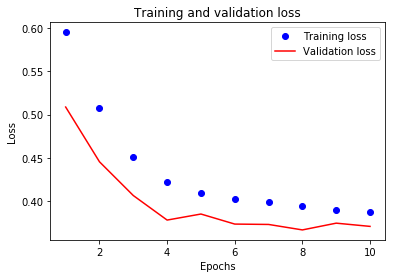

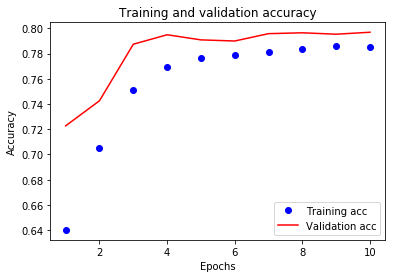

In [12]:
# Learning curves

# VALIDATION LOSS curves

plt.clf()
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history_dict['loss']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# VALIDATION ACCURACY curves

plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, (len(history_dict['acc']) + 1))
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
# Final Predict on test

final_predictions = model.predict(x_test)
print(final_predictions)

# Modify the raw final_predictions - prediction probs  - into 0 and 1
# Cutoff point = 0.5

Preds = final_predictions.copy()
print(len(Preds))

Preds[ np.where( Preds >= 0.5 ) ] = 1
Preds[ np.where( Preds < 0.5 ) ] = 0
print(Preds)

[[0.3830242 ]
 [0.17060086]
 [0.2878614 ]
 ...
 [0.9990678 ]
 [0.4599644 ]
 [0.2878614 ]]
10000
[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [0.]
 [0.]]


# RESULTS
* The guessing, sanity check, baseline accuracy is 50% as the dataset is balanced
* All the results below are on the test dataset only - which the model was not exposed to during training / validation
* Confusion matrix, precision , recall, F! score and ROC AUC in addition to accuracy

In [14]:
# Confusion matrix

conf_mx = confusion_matrix(y_test, Preds)

TN = conf_mx[0,0]
FP = conf_mx[0,1]
FN = conf_mx[1,0]
TP = conf_mx[1,1]

print ('TN: ', TN)
print ('FP: ', FP)
print ('FN: ', FN)
print ('TP: ', TP)

recall = TP/(TP+FN)
precision = TP/(TP+FP)

print (recall, precision)

TN:  4622
FP:  355
FN:  1691
TP:  3332
0.6633485964563011 0.9037157580688907


In [15]:
# Function to visualize the confusion matrix

def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,
                          normalize=False):
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

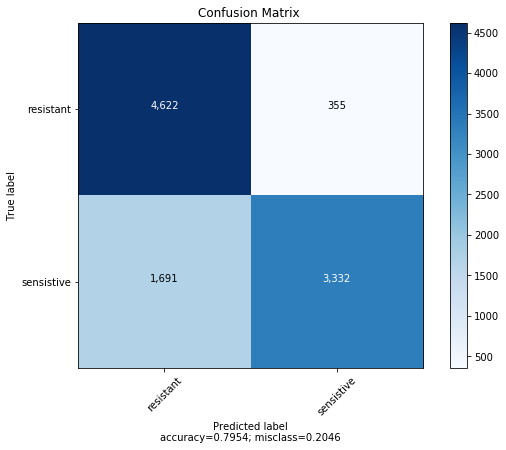

In [16]:
plot_confusion_matrix(conf_mx, 
                      normalize    = False,
                      target_names = ['resistant', 'sensistive'],
                      title        = "Confusion Matrix ")

In [17]:
print ('precision ',precision_score(y_test, Preds))
print ('recall ',recall_score(y_test, Preds) )
print ('accuracy ',accuracy_score(y_test, Preds))
print ('F1 score ',f1_score(y_test, Preds))

precision  0.9037157580688907
recall  0.6633485964563011
accuracy  0.7954
F1 score  0.7650975889781861


AUC: 0.796


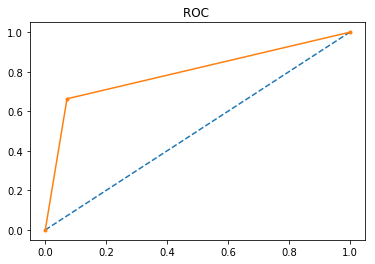

In [18]:
# AUC/ROC curves should be used when there are roughly equal numbers of observations for each class
# Precision-Recall curves should be used when there is a moderate to large class imbalance

# calculate AUC
auc = roc_auc_score(y_test, Preds)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, Preds)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.title('ROC ')
plt.show()

f1=0.765 ap=0.769


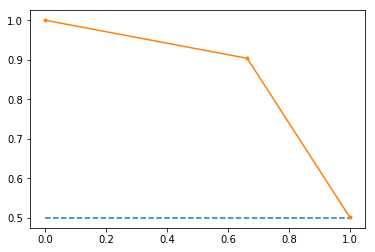

In [19]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, Preds)
# calculate F1 score
f1 = f1_score(y_test, Preds)
# calculate average precision score
ap = average_precision_score(y_test, Preds)
print('f1=%.3f ap=%.3f' % (f1, ap))
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the roc curve for the model
plt.plot(recall, precision, marker='.')
plt.show()

# Codons instead of nucleotides ... from 81% to 99%

In [20]:
# From nucleotides to codons ... w/o considering the start / stop codons as the data is synthetic and may not have these

DataCod = DataDf.copy()

Codons = list(DataCod['genes'])
print(len(Codons))

for n in range(len(Codons)):
    Codons[n] = list([Codons[n][i:i+3] for i in range(0, len(Codons[n]), 3)])
    
DataCod['codons'] = Codons
DataCod

100000


,resistant,genes,codons
0,False,ATGCACTACCGTATGATCCCCCTTCACTGGATGATGGAAATTGACT...,"[ATG, CAC, TAC, CGT, ATG, ATC, CCC, CTT, CAC, ..."
1,False,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...,"[ATG, CAC, TAC, CGT, ATG, ATT, CAC, TGG, ATG, ..."
2,False,ATGCACTACCGTATGATTCACTGGATCGTGATGGAAATTGACTGCA...,"[ATG, CAC, TAC, CGT, ATG, ATT, CAC, TGG, ATC, ..."
3,False,ATGCACTACCGTATGATTCACTGGGTGATGGAAATTGACTGCAATG...,"[ATG, CAC, TAC, CGT, ATG, ATT, CAC, TGG, GTG, ..."
4,False,ATGCACGACCGTATCATTCACTGGATGATGGAAATTGACTGCAATG...,"[ATG, CAC, GAC, CGT, ATC, ATT, CAC, TGG, ATG, ..."
5,False,ATGCACTACCGTATGATTCGCTGGATGATGGAAATTGACTGCAATG...,"[ATG, CAC, TAC, CGT, ATG, ATT, CGC, TGG, ATG, ..."
6,True,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...,"[ATG, CAC, TAC, CGT, ATG, ATT, CAC, TGG, ATG, ..."
7,True,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...,"[ATG, CAC, TAC, CGT, ATG, ATT, CAC, TGG, ATG, ..."
8,False,ATGCACTATATGATTCACTGGATGATGGAAATTGACTGCAATGGCT...,"[ATG, CAC, TAT, ATG, ATT, CAC, TGG, ATG, ATG, ..."
9,True,ATGCACTACCGTATGATTCACTGGATGATGGAAACTTGACTGCAAT...,"[ATG, CAC, TAC, CGT, ATG, ATT, CAC, TGG, ATG, ..."


In [21]:
# Tokenize from codons to integers (sequences and then pad / truncate data)

maxlen = 53 # cut off after this number of codons in a list

max_words = 64 # considers only the top number of codons  in the dictionary (It finds 66 below because of 'a' and 'ga')
max_features = max_words

#tokenizer = Tokenizer(num_words=max_words, char_level=True)
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(list(DataCod['codons']))
sequences = tokenizer.texts_to_sequences(list(DataCod['codons']))
word_index = tokenizer.word_index
Xpad = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post', value=0)

print('Found %s unique tokens.' % len(word_index))
print('word_index', word_index)

Found 66 unique tokens.
word_index {'cac': 1, 'cgt': 2, 'aat': 3, 'atg': 4, 'tac': 5, 'att': 6, 'tgg': 7, 'gac': 8, 'tgc': 9, 'act': 10, 'gtt': 11, 'gaa': 12, 'aaa': 13, 'cag': 14, 'tga': 15, 'ttg': 16, 'gct': 17, 'ttc': 18, 'tct': 19, 'ggc': 20, 'aca': 21, 'taa': 22, 'ctg': 23, 'ata': 24, 'caa': 25, 'ctt': 26, 'tcg': 27, 'gtc': 28, 'aac': 29, 'gga': 30, 'acg': 31, 'gca': 32, 'tta': 33, 'cta': 34, 'acc': 35, 'gat': 36, 'tca': 37, 'tat': 38, 'agg': 39, 'tgt': 40, 'gtg': 41, 'cga': 42, 'cgc': 43, 'ttt': 44, 'aga': 45, 'ggt': 46, 'ctc': 47, 'cca': 48, 'ccg': 49, 'gcg': 50, 'a': 51, 'ga': 52, 'tag': 53, 'atc': 54, 'cat': 55, 'agt': 56, 'cgg': 57, 'aag': 58, 'gag': 59, 'cct': 60, 'gta': 61, 'ggg': 62, 'tcc': 63, 'agc': 64, 'ccc': 65, 'gcc': 66}


In [22]:
# Separate the label

labels = np.asarray(DataCod['resistant'])
print(Xpad.shape)
print(labels.shape)

(100000, 53)
(100000,)


In [23]:
# Check a sample

rowNum = 37149
print(DataCod['genes'][rowNum])
print(DataCod['codons'][rowNum])
print(sequences[rowNum])
print(Xpad[rowNum])
print(labels[rowNum])

ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA
['ATG', 'CAC', 'TAC', 'CGT', 'ATG', 'ATT', 'CAC', 'TGG', 'ATG', 'ATG', 'GAA', 'ATT', 'GAC', 'TGC', 'AAT', 'GGC', 'TGC', 'GCT', 'AAT', 'AAT', 'ACT', 'TTG', 'TCT', 'CGT', 'CGT', 'TGG', 'AAT', 'TAC', 'GAC', 'TTC', 'TGG', 'CAC', 'AAA', 'CAC', 'GTT', 'GAA', 'CAG', 'GTT', 'AAA', 'TGC', 'TAC', 'CGT', 'CAC', 'AAT', 'ATT', 'CGT', 'GAC', 'CAG', 'ACT', 'TGA']
[4, 1, 5, 2, 4, 6, 1, 7, 4, 4, 12, 6, 8, 9, 3, 20, 9, 17, 3, 3, 10, 16, 19, 2, 2, 7, 3, 5, 8, 18, 7, 1, 13, 1, 11, 12, 14, 11, 13, 9, 5, 2, 1, 3, 6, 2, 8, 14, 10, 15]
[ 4  1  5  2  4  6  1  7  4  4 12  6  8  9  3 20  9 17  3  3 10 16 19  2
  2  7  3  5  8 18  7  1 13  1 11 12 14 11 13  9  5  2  1  3  6  2  8 14
 10 15  0  0  0]
True


In [24]:
# Create train & val and test datasets with inital shuffle (as the original dataset may be arranged)

training_samples = int(Xpad.shape[0] * 0.9)
# The validation is being taken by keras - below
# test = remaining

indices = np.arange(Xpad.shape[0])
np.random.shuffle(indices) # FOR TESTING PURPOSES comment it out - to keep indices as above

Xpad = Xpad[indices]
labels = labels[indices]

x_train = Xpad[:training_samples]
y_train = labels[:training_samples]
x_test = Xpad[training_samples: ]
y_test = labels[training_samples: ]

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)

x_train (90000, 53)
y_train (90000,)
x_test (10000, 53)
y_test (10000,)


In [25]:
# Model ... 64 CNN window 27 & Bidirectional GRU accuracy = 0.99

model = Sequential()
model.add(Embedding(64, 1, input_length=maxlen))
model.add(layers.Conv1D(128, 27, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, 9, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Bidirectional(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 53, 1)             64        
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 27, 128)           3584      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 9, 128)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 9, 128)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1, 128)            147584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                30912     
__________

In [26]:
# Train / Validate model

history = model.fit(x_train, y_train,
epochs = 10,
batch_size=32,
validation_split=0.2)

Train on 72000 samples, validate on 18000 samples
Epoch 1/10
72000/72000 [==============================] - 27s 377us/step - loss: 0.1094 - acc: 0.9514 - val_loss: 0.0420 - val_acc: 0.9894
Epoch 2/10
72000/72000 [==============================] - 25s 346us/step - loss: 0.0438 - acc: 0.9877 - val_loss: 0.0378 - val_acc: 0.9894
Epoch 3/10
72000/72000 [==============================] - 25s 347us/step - loss: 0.0410 - acc: 0.9879 - val_loss: 0.0363 - val_acc: 0.9894
Epoch 4/10
72000/72000 [==============================] - 25s 347us/step - loss: 0.0400 - acc: 0.9878 - val_loss: 0.0356 - val_acc: 0.9893
Epoch 5/10
72000/72000 [==============================] - 25s 347us/step - loss: 0.0390 - acc: 0.9879 - val_loss: 0.0353 - val_acc: 0.9895
Epoch 6/10
72000/72000 [==============================] - 25s 346us/step - loss: 0.0383 - acc: 0.9880 - val_loss: 0.0366 - val_acc: 0.9894
Epoch 7/10
72000/72000 [==============================] - 25s 346us/step - loss: 0.0382 - acc: 0.9879 - val_loss: 0.

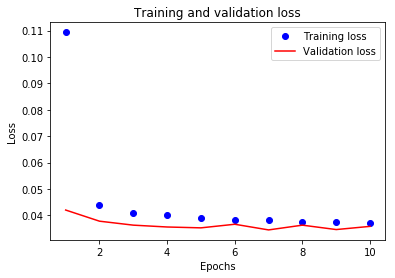

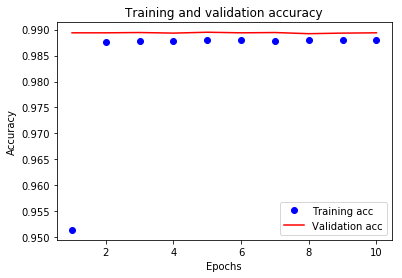

In [27]:
# Learning curves

# VALIDATION LOSS curves

plt.clf()
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history_dict['loss']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# VALIDATION ACCURACY curves

plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, (len(history_dict['acc']) + 1))
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
# Final Predict on test

final_predictions = model.predict(x_test)
print(final_predictions)

# Modify the raw final_predictions - prediction probs  - into 0 and 1
# Cutoff point = 0.5

Preds = final_predictions.copy()
print(len(Preds))

Preds[ np.where( Preds >= 0.5 ) ] = 1
Preds[ np.where( Preds < 0.5 ) ] = 0
print(Preds)

[[9.9989748e-01]
 [5.2720308e-05]
 [9.9989748e-01]
 ...
 [9.9989748e-01]
 [1.6429460e-01]
 [9.9989545e-01]]
10000
[[1.]
 [0.]
 [1.]
 ...
 [1.]
 [0.]
 [1.]]


In [29]:
# Confusion matrix

conf_mx = confusion_matrix(y_test, Preds)

TN = conf_mx[0,0]
FP = conf_mx[0,1]
FN = conf_mx[1,0]
TP = conf_mx[1,1]

print ('TN: ', TN)
print ('FP: ', FP)
print ('FN: ', FN)
print ('TP: ', TP)

recall = TP/(TP+FN)
precision = TP/(TP+FP)

print (recall, precision)

TN:  5096
FP:  0
FN:  107
TP:  4797
0.9781810766721044 1.0


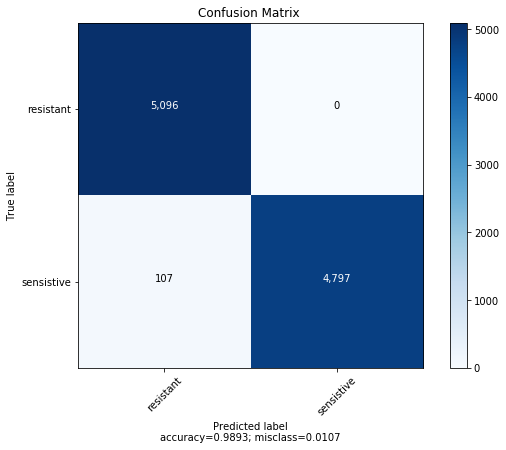

In [30]:
plot_confusion_matrix(conf_mx, 
                      normalize    = False,
                      target_names = ['resistant', 'sensistive'],
                      title        = "Confusion Matrix ")

AUC: 0.989


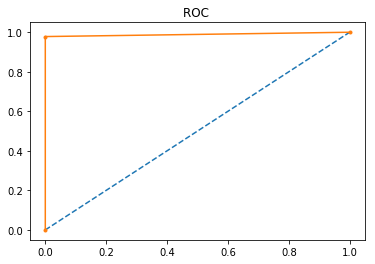

In [31]:
# AUC/ROC curves should be used when there are roughly equal numbers of observations for each class
# Precision-Recall curves should be used when there is a moderate to large class imbalance

# calculate AUC
auc = roc_auc_score(y_test, Preds)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, Preds)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.title('ROC ')
plt.show()

f1=0.989 ap=0.989


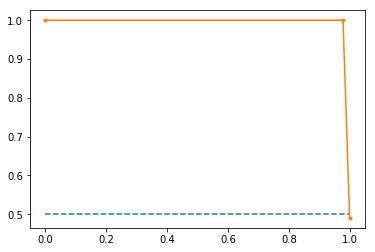

In [32]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, Preds)
# calculate F1 score
f1 = f1_score(y_test, Preds)
# calculate average precision score
ap = average_precision_score(y_test, Preds)
print('f1=%.3f ap=%.3f' % (f1, ap))
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the roc curve for the model
plt.plot(recall, precision, marker='.')
plt.show()